# Define sub-regions

Split the whole Central Europe to sub-regions based on their morphological continuity.

In [1]:
import os

import dask.dataframe as dd
import geopandas as gpd
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN

os.getenv("DOCKER_ENV_VERSION")

/tmp/ipykernel_892/3511532706.py:6: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


'1.0'

Read all centroids.

In [2]:
data = dd.read_parquet("../data/centroids/*").compute()

Aggregate to 100x100m grid and use count as weight for DBSCAN.

In [3]:
data[["x_100", "y_100"]] = np.around(data[["x", "y"]], decimals=-2)
grid = data[["id", "x_100", "y_100"]].groupby(["x_100", "y_100"]).count().reset_index()

Fit DBSCAN with 400 meters distance.

In [4]:
dbscan = DBSCAN(400, n_jobs=-1).fit(grid[["x_100", "y_100"]], sample_weight=grid["id"])

Assing labels to groups.

In [5]:
grid["labels"] = dbscan.labels_

Merge labes to original non-aggregated points.

In [6]:
data = pd.merge(data, grid, "left", on=["x_100", "y_100"])

## Cores

Identify _core_ urban areas (with more than 10k buildings within a single cluster).

In [7]:
counts = data.labels.value_counts()
data["core"] = data.labels.isin(counts[counts > 10000].index.drop(-1))

Count number of core areas.

In [8]:
(counts > 10000).sum()

605

Count number of buildings in core areas.

In [9]:
cores = data[data.core]
cores.shape

(36395466, 8)

Create plottable boundaries of core groups.

In [10]:
grid["core"] = grid.labels.isin(counts[counts > 10000].index.drop(-1))
grid_cores = grid[grid.core]
grid_cores = gpd.GeoDataFrame(
    grid_cores["labels"],
    geometry=gpd.points_from_xy(grid_cores["x_100"], grid_cores["y_100"]),
    crs=3035,
)
grid_cores_dissolved = grid_cores.dissolve("labels")

Plot an overview.

<AxesSubplot: >

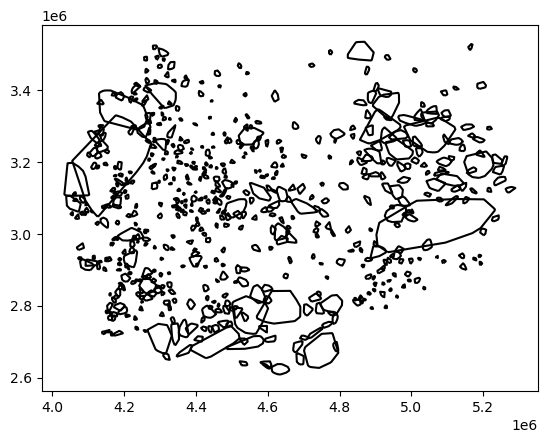

In [11]:
grid_cores_dissolved.convex_hull.boundary.plot(color="k")

## Nearest core

Assign each non-core cluster and non-core building without a cluster to the nearest cluster. Done using the grid for efficiency.

In [12]:
grid_non_cores = grid[~grid.core]
grid_non_cores = gpd.GeoDataFrame(
    grid_non_cores["labels"],
    geometry=gpd.points_from_xy(grid_non_cores["x_100"], grid_non_cores["y_100"]),
    crs=3035,
)

Check the sizes of the split core/non-core grid.

In [13]:
grid_cores.shape

(4732901, 2)

In [14]:
grid_non_cores.shape

(5794474, 2)

Split outliers away to treat them individually.

In [15]:
grid_non_cores_clustered = grid_non_cores[grid_non_cores.labels != -1]
grid_non_cores_outliers = grid_non_cores[grid_non_cores.labels == -1]

Dissolve into clusters.

In [16]:
grid_non_cores_clustered_dissolved = grid_non_cores_clustered.dissolve("labels")

Find nearest core for each cluster.

In [17]:
%%time
nearest = grid_cores.sindex.nearest(grid_non_cores_clustered_dissolved.geometry, return_all=False)

CPU times: user 34.9 s, sys: 128 ms, total: 35 s
Wall time: 35 s


Assing nearest core labels.

In [18]:
grid_non_cores_clustered_dissolved["nearest_core"] = grid_cores.labels.values[
    nearest[1]
]

Repeat for outliers.

In [19]:
%%time
nearest_outliers = grid_cores.sindex.nearest(grid_non_cores_outliers.geometry, return_all=False)

CPU times: user 2.72 s, sys: 0 ns, total: 2.72 s
Wall time: 2.72 s


In [20]:
grid_non_cores_outliers["nearest_core"] = grid_cores.labels.values[nearest_outliers[1]]

/opt/conda/lib/python3.10/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


Concatenate non-outliers and outliers while exploding the dissolved clusters to get grid cells.

In [21]:
grid_non_cores = pd.concat(
    [
        grid_non_cores_clustered_dissolved.reset_index().explode(ignore_index=True),
        grid_non_cores_outliers,
    ],
    ignore_index=True,
)

Merge resulting labels back to point data.

In [22]:
grid_non_cores["x_100"] = grid_non_cores.geometry.x
grid_non_cores["y_100"] = grid_non_cores.geometry.y

In [23]:
data = pd.merge(
    data,
    grid_non_cores[["x_100", "y_100", "nearest_core"]],
    "left",
    on=["x_100", "y_100"],
)

## Finalize

Create final region label.

In [24]:
data["region"] = data.labels
data.loc[~data.core, "region"] = data.loc[~data.core, "nearest_core"]

In [25]:
data

,id_x,x,y,x_100,y_100,id_y,labels,core,nearest_core,region
0,v0.1-AUT.1.2.1_1-0,4.808062e+06,2.769749e+06,4808100.0,2769700.0,3,95339,False,91536.0,91536
1,v0.1-AUT.1.2.1_1-1,4.808114e+06,2.770025e+06,4808100.0,2770000.0,3,95339,False,91536.0,91536
2,v0.1-AUT.1.2.1_1-2,4.808163e+06,2.770044e+06,4808200.0,2770000.0,2,95339,False,91536.0,91536
3,v0.1-AUT.1.2.1_1-3,4.808119e+06,2.770064e+06,4808100.0,2770100.0,13,95339,False,91536.0,91536
4,v0.1-AUT.1.2.1_1-4,4.808156e+06,2.770032e+06,4808200.0,2770000.0,2,95339,False,91536.0,91536
...,...,...,...,...,...,...,...,...,...,...
69718166,v0.1-SVK.8.11_1-101889,4.968921e+06,2.939664e+06,4968900.0,2939700.0,12,112422,True,NaN,112422
69718167,v0.1-SVK.8.11_1-101890,4.968662e+06,2.941190e+06,4968700.0,2941200.0,10,112422,True,NaN,112422
69718168,v0.1-SVK.8.11_1-101891,4.969222e+06,2.939583e+06,4969200.0,2939600.0,27,112422,True,NaN,112422
69718169,v0.1-SVK.8.11_1-101892,4.969260e+06,2.939506e+06,4969300.0,2939500.0,23,112422,True,NaN,112422


Rename columns.

In [26]:
data = data.rename(
    columns={
        "id_x": "id",
        "id_y": "weight",
        "labels": "dbscan_cluster",
    }
)

In [27]:
data

,id,x,y,x_100,y_100,weight,dbscan_cluster,core,nearest_core,region
0,v0.1-AUT.1.2.1_1-0,4.808062e+06,2.769749e+06,4808100.0,2769700.0,3,95339,False,91536.0,91536
1,v0.1-AUT.1.2.1_1-1,4.808114e+06,2.770025e+06,4808100.0,2770000.0,3,95339,False,91536.0,91536
2,v0.1-AUT.1.2.1_1-2,4.808163e+06,2.770044e+06,4808200.0,2770000.0,2,95339,False,91536.0,91536
3,v0.1-AUT.1.2.1_1-3,4.808119e+06,2.770064e+06,4808100.0,2770100.0,13,95339,False,91536.0,91536
4,v0.1-AUT.1.2.1_1-4,4.808156e+06,2.770032e+06,4808200.0,2770000.0,2,95339,False,91536.0,91536
...,...,...,...,...,...,...,...,...,...,...
69718166,v0.1-SVK.8.11_1-101889,4.968921e+06,2.939664e+06,4968900.0,2939700.0,12,112422,True,NaN,112422
69718167,v0.1-SVK.8.11_1-101890,4.968662e+06,2.941190e+06,4968700.0,2941200.0,10,112422,True,NaN,112422
69718168,v0.1-SVK.8.11_1-101891,4.969222e+06,2.939583e+06,4969200.0,2939600.0,27,112422,True,NaN,112422
69718169,v0.1-SVK.8.11_1-101892,4.969260e+06,2.939506e+06,4969300.0,2939500.0,23,112422,True,NaN,112422


Save.

In [28]:
data.to_parquet("../data/regions/id_to_region.parquet")

Visualise sample of locations and indicate centre of each region.

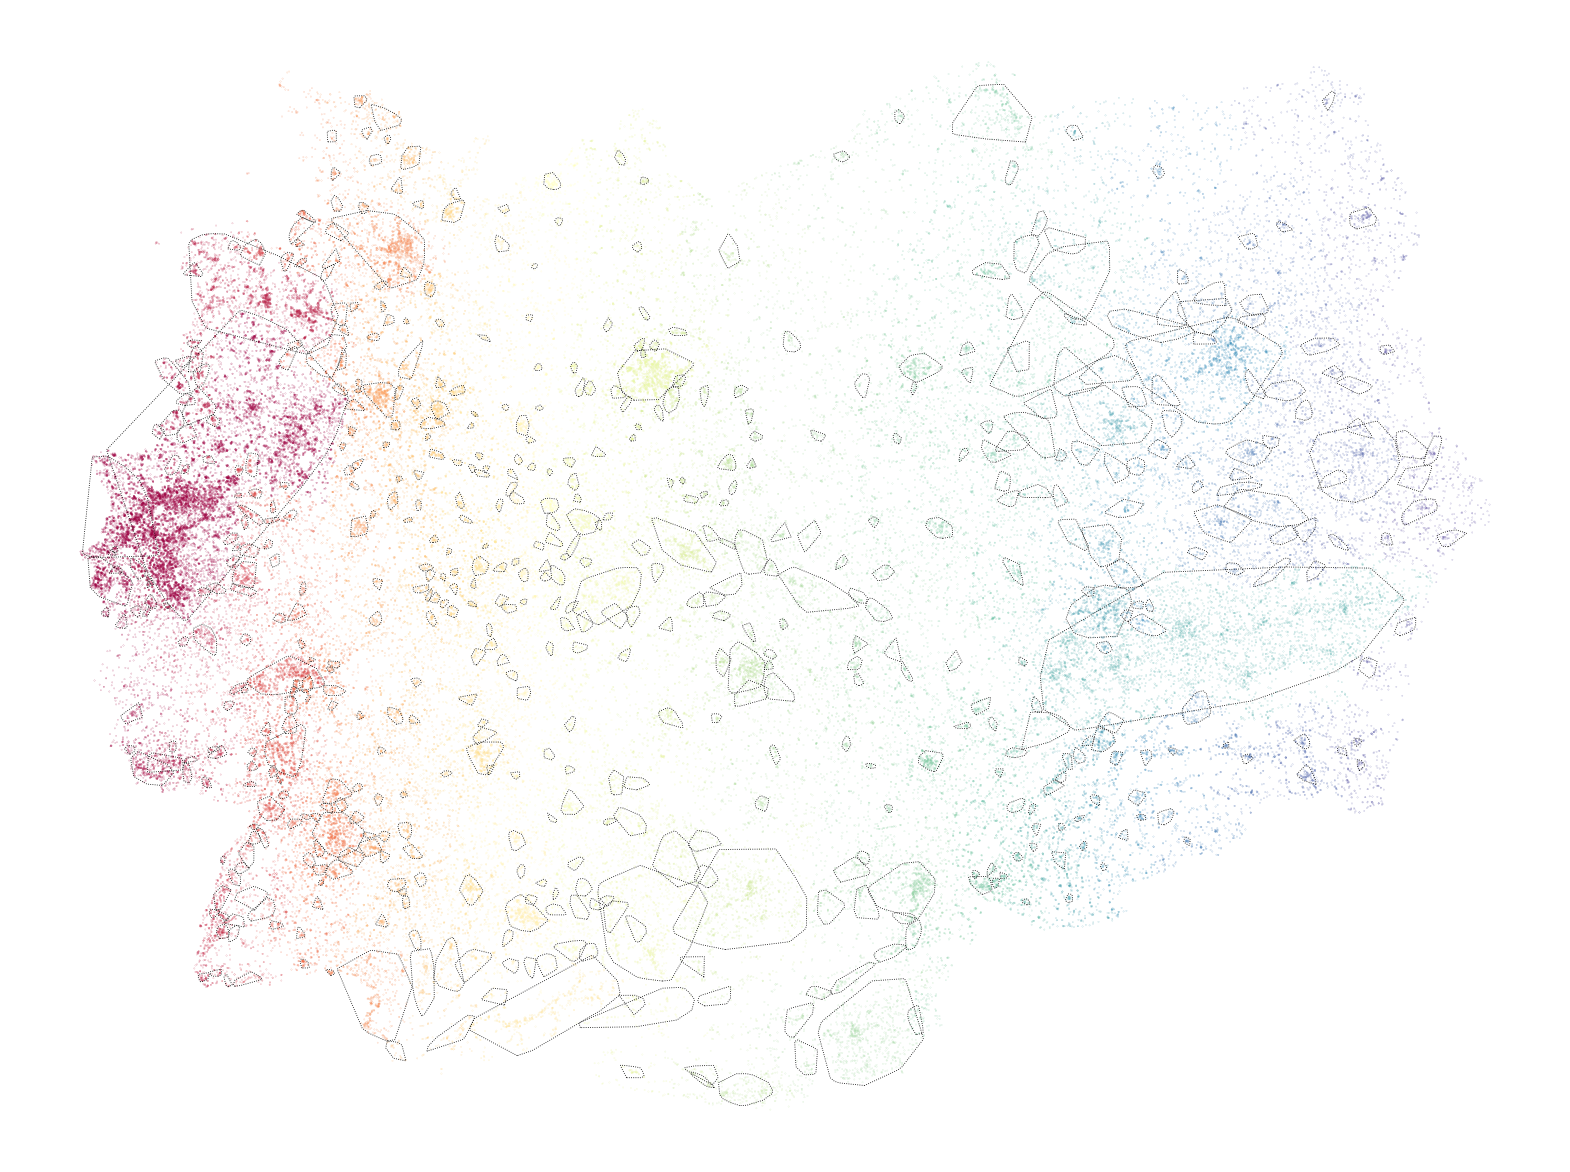

In [34]:
sample = data.sample(100_000)
ax = gpd.GeoDataFrame(
    sample, geometry=gpd.points_from_xy(sample.x, sample.y), crs=3035
).plot(
    "region", figsize=(20, 20), s=0.01, cmap="Spectral", categorical=True, legend=False
)
grid_cores_dissolved.convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.6, linestyle="dotted"
)
ax.set_axis_off()

Visualise sample of locations and indicate extent of each region.

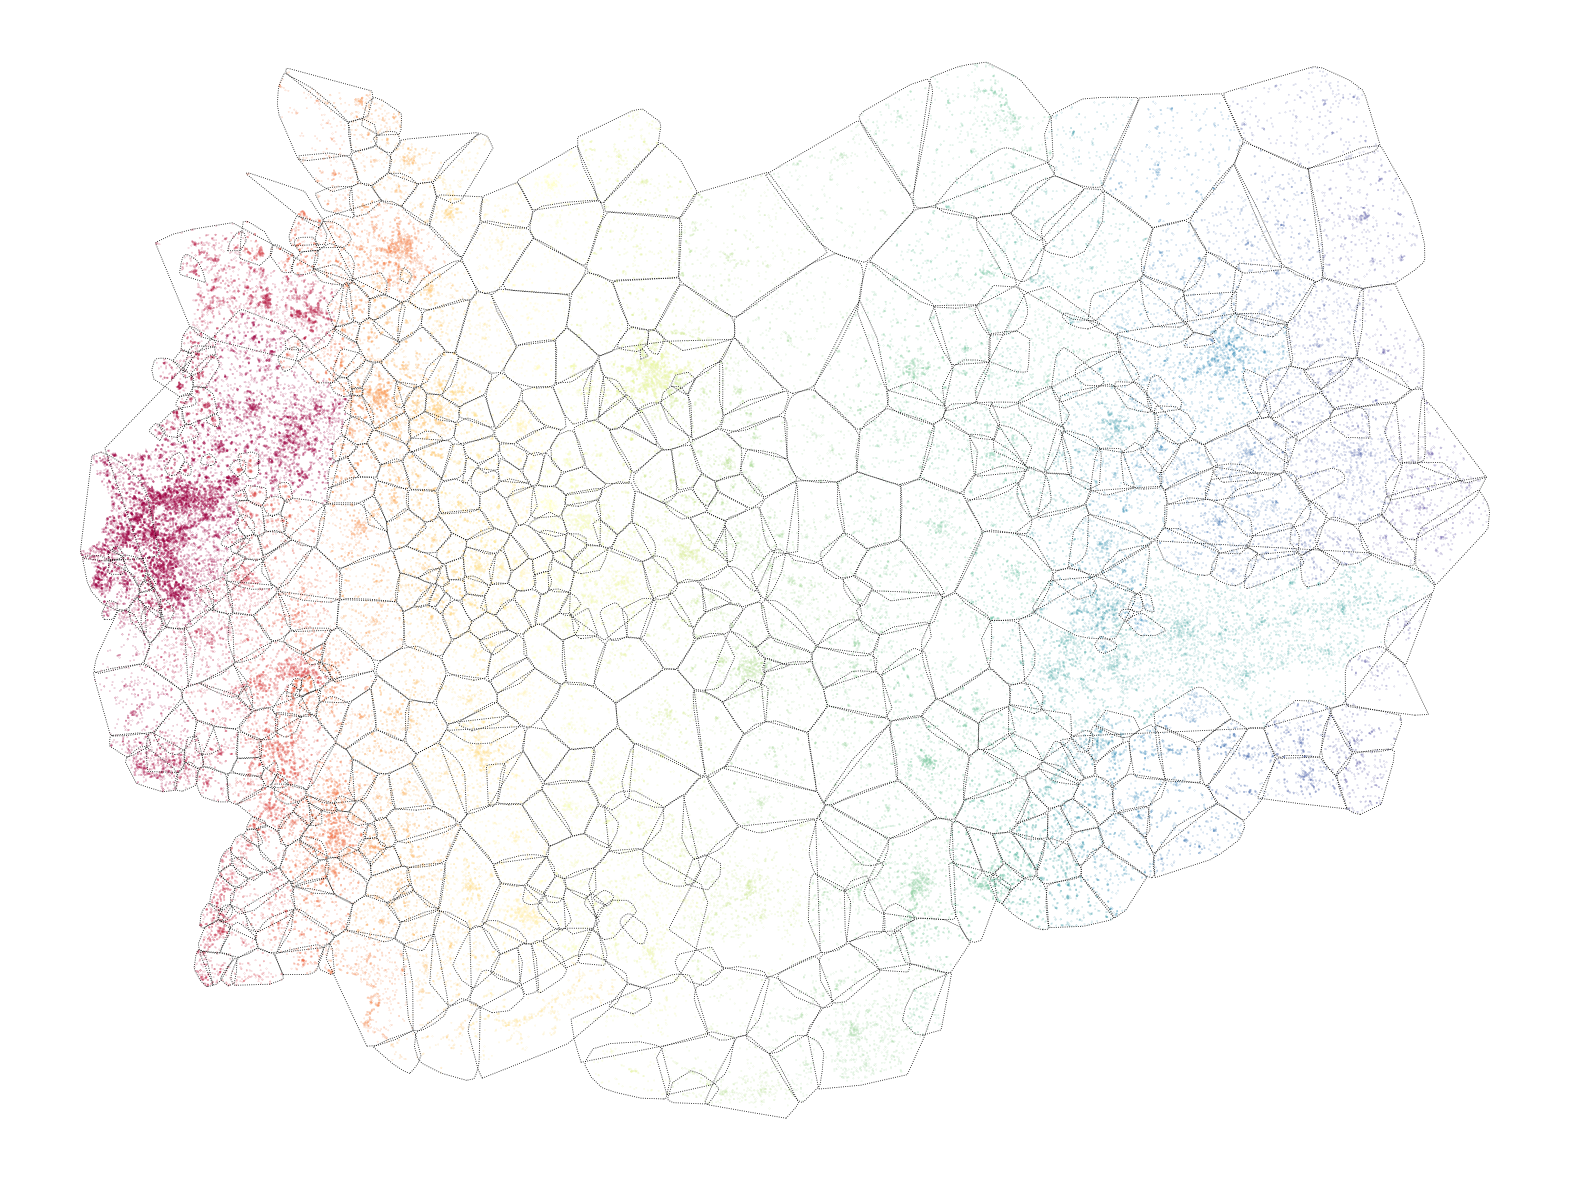

In [37]:
ax = gpd.GeoDataFrame(
    sample, geometry=gpd.points_from_xy(sample.x, sample.y), crs=3035
).plot(
    "region", figsize=(20, 20), s=0.01, cmap="Spectral", categorical=True, legend=False
)
pd.concat(
    [
        grid_cores,
        grid_non_cores[["nearest_core", "geometry"]].rename(
            columns={"nearest_core": "labels"}
        ),
    ]
).dissolve("labels").convex_hull.boundary.plot(
    ax=ax, color="k", linewidth=0.6, linestyle="dotted"
)
ax.set_axis_off()

Save convex hulls to Parrquet.

In [38]:
grid_cores_dissolved.convex_hull.to_frame("convex_hull").to_parquet(
    "../data/regions/cores_hull.parquet"
)
pd.concat(
    [
        grid_cores,
        grid_non_cores[["nearest_core", "geometry"]].rename(
            columns={"nearest_core": "labels"}
        ),
    ]
).dissolve("labels").convex_hull.to_frame("convex_hull").to_parquet(
    "../data/regions/regions_hull.parquet"
)